In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [7]:
# 1. LOAD PROFILING
def create_load_profile():
    """Generate hourly load profile for village components"""
    hours = np.arange(0, 24)

    # Load components (kW)
    homes = np.array([0.5, 0.3, 0.2, 0.1, 0.1, 0.2, 1.2, 2.5, 3.0, 2.8, 2.5, 2.8,
                     3.2, 3.5, 3.8, 4.2, 5.5, 7.2, 8.5, 6.8, 4.2, 2.8, 1.5, 0.8])

    school = np.array([0, 0, 0, 0, 0, 0, 0.5, 1.2, 1.8, 1.8, 1.8, 1.8,
                      1.5, 1.8, 1.8, 1.8, 0.8, 0, 0, 0, 0, 0, 0, 0])

    irrigation = np.array([2.5, 2.5, 2.5, 2.5, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0,
                          6.5, 7.0, 6.5, 6.0, 5.5, 4.5, 3.5, 3.0, 2.5, 2.5, 2.5, 2.5])

    anganwadi = np.array([0, 0, 0, 0, 0, 0, 0.3, 0.8, 1.2, 1.2, 1.2, 1.2,
                         1.0, 1.2, 1.2, 1.0, 0.5, 0, 0, 0, 0, 0, 0, 0])

    total_load = homes + school + irrigation + anganwadi

    return pd.DataFrame({
        'Hour': hours,
        'Homes': homes,
        'School': school,
        'Irrigation': irrigation,
        'Anganwadi': anganwadi,
        'Total_Load': total_load
    })


In [8]:

# 2. SOLAR RESOURCE ASSESSMENT
def generate_solar_data():
    """Generate solar irradiance data for Indian village"""
    np.random.seed(42)
    days = 365
    hours_per_day = 24

    # Monthly average solar irradiance (kWh/m²/day) for India
    monthly_avg = [4.2, 5.1, 6.2, 7.1, 7.8, 7.2, 6.8, 6.5, 6.2, 5.8, 4.8, 4.0]

    solar_data = []
    for month in range(12):
        days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31][month]
        for day in range(days_in_month):
            daily_irradiance = []
            peak_hour = 12  # Solar noon
            for hour in range(24):
                if 6 <= hour <= 18:  # Daylight hours
                    # Bell curve for solar irradiance
                    irradiance = monthly_avg[month] * np.exp(-0.5 * ((hour - peak_hour) / 3)**2)
                    irradiance *= np.random.uniform(0.8, 1.2)  # Weather variation
                else:
                    irradiance = 0
                daily_irradiance.append(max(0, irradiance))
            solar_data.extend(daily_irradiance)

    return np.array(solar_data[:365*24])


In [9]:

# 3. SYSTEM SIZING CALCULATIONS
def size_system(load_profile, solar_irradiance):
    """Calculate solar PV and battery sizing"""
    daily_energy_demand = load_profile['Total_Load'].sum()  # kWh/day
    peak_load = load_profile['Total_Load'].max()  # kW

    # Solar PV sizing (with 1.3 safety factor)
    avg_daily_solar = np.mean([solar_irradiance[i:i+24].sum() for i in range(0, len(solar_irradiance), 24)])
    pv_capacity = (daily_energy_demand * 1.3) / avg_daily_solar

    # Battery sizing (2 days autonomy)
    battery_capacity = daily_energy_demand * 2

    # Inverter sizing
    inverter_capacity = peak_load * 1.25

    return {
        'PV_Capacity_kW': round(pv_capacity, 2),
        'Battery_Capacity_kWh': round(battery_capacity, 2),
        'Inverter_Capacity_kW': round(inverter_capacity, 2),
        'Daily_Energy_Demand_kWh': round(daily_energy_demand, 2),
        'Peak_Load_kW': round(peak_load, 2)
    }


In [10]:

# 4. ECONOMIC ANALYSIS
def economic_analysis(system_specs):
    """Calculate LCOE and financial metrics"""
    # Cost assumptions (INR)
    pv_cost_per_kw = 45000  # INR/kW
    battery_cost_per_kwh = 12000  # INR/kWh
    inverter_cost_per_kw = 8000  # INR/kW
    installation_cost = 50000  # INR

    # CAPEX calculation
    pv_cost = system_specs['PV_Capacity_kW'] * pv_cost_per_kw
    battery_cost = system_specs['Battery_Capacity_kWh'] * battery_cost_per_kwh
    inverter_cost = system_specs['Inverter_Capacity_kW'] * inverter_cost_per_kw
    total_capex = pv_cost + battery_cost + inverter_cost + installation_cost

    # OPEX (2% of CAPEX annually)
    annual_opex = total_capex * 0.02

    # LCOE calculation (25 years, 8% discount rate)
    project_life = 25
    discount_rate = 0.08
    annual_energy = system_specs['Daily_Energy_Demand_kWh'] * 365

    # Present value factors
    pv_factor = sum([(1 + discount_rate)**(-i) for i in range(1, project_life + 1)])
    lcoe = (total_capex + annual_opex * pv_factor) / (annual_energy * pv_factor)

    return {
        'Total_CAPEX_INR': total_capex,
        'Annual_OPEX_INR': annual_opex,
        'LCOE_INR_per_kWh': round(lcoe, 2),
        'PV_Cost': pv_cost,
        'Battery_Cost': battery_cost,
        'Inverter_Cost': inverter_cost
    }


In [11]:

# Generate data
load_data = create_load_profile()
solar_irradiance = generate_solar_data()
system_specs = size_system(load_data, solar_irradiance)
economics = economic_analysis(system_specs)


In [12]:
# PLOTTING SECTION
fig = plt.figure(figsize=(10, 6))

<Figure size 2000x1500 with 0 Axes>

([<matplotlib.axis.XTick at 0x7cf29665f550>,
 [Text(0, 0, '0'),
  Text(4, 0, '4'),
  Text(8, 0, '8'),
  Text(12, 0, '12'),
  Text(16, 0, '16'),
  Text(20, 0, '20'),
  Text(24, 0, '24')])

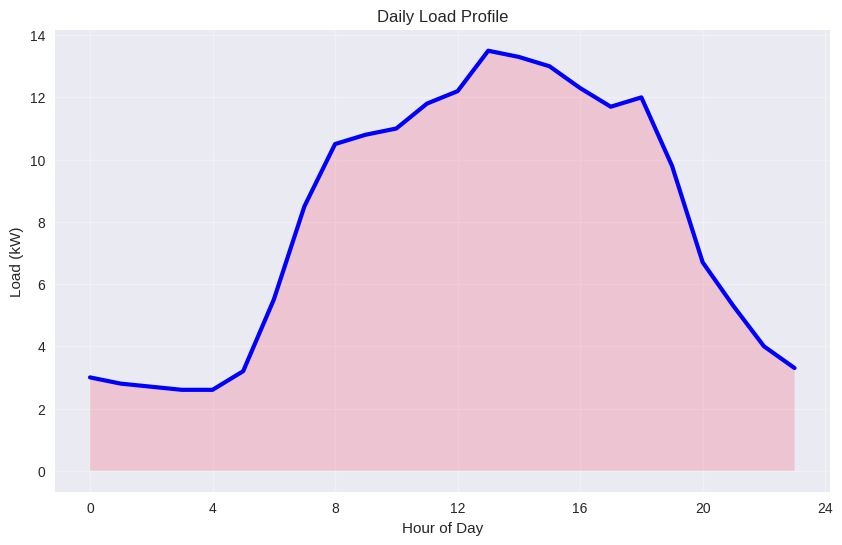

In [15]:
# PLOTTING SECTION
fig = plt.figure(figsize=(10, 6))

# Plot 1: Daily Load Profile

plt.plot(load_data['Hour'], load_data['Total_Load'], 'b-', linewidth=3, label='Total Load')
plt.fill_between(load_data['Hour'], load_data['Total_Load'], alpha=0.3)
plt.xlabel('Hour of Day')
plt.ylabel('Load (kW)')
plt.title('Daily Load Profile')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 25, 4))

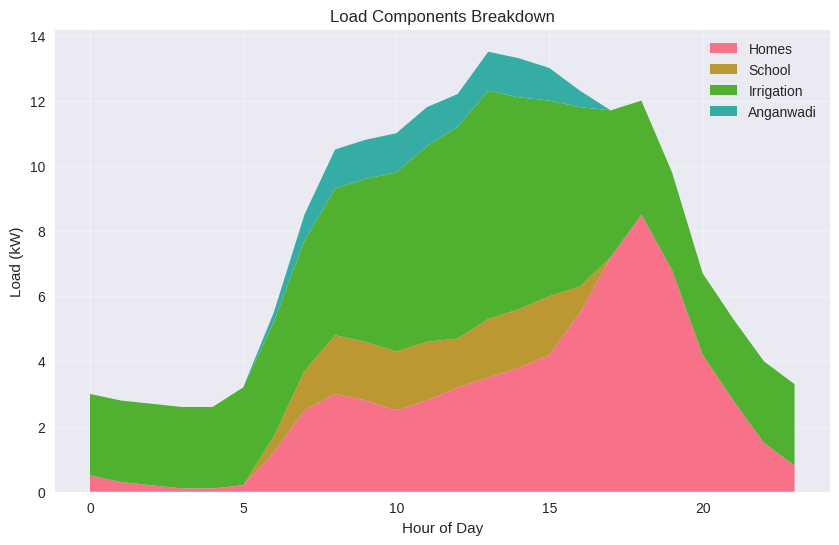

In [16]:


# Plot 2: Load Components Breakdown
fig = plt.figure(figsize=(10, 6))
plt.stackplot(load_data['Hour'], load_data['Homes'], load_data['School'],
              load_data['Irrigation'], load_data['Anganwadi'],
              labels=['Homes', 'School', 'Irrigation', 'Anganwadi'])
plt.xlabel('Hour of Day')
plt.ylabel('Load (kW)')
plt.title('Load Components Breakdown')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

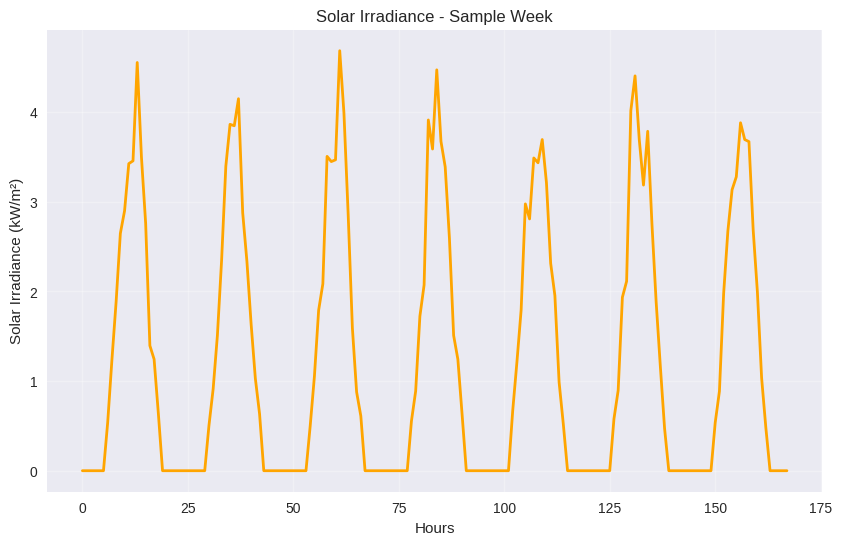

In [17]:
# Plot 3: Solar Irradiance (Sample Week)
fig = plt.figure(figsize=(10, 6))
sample_week = solar_irradiance[:168]  # First week
hours_week = np.arange(len(sample_week))
plt.plot(hours_week, sample_week, 'orange', linewidth=2)
plt.xlabel('Hours')
plt.ylabel('Solar Irradiance (kW/m²)')
plt.title('Solar Irradiance - Sample Week')
plt.grid(True, alpha=0.3)

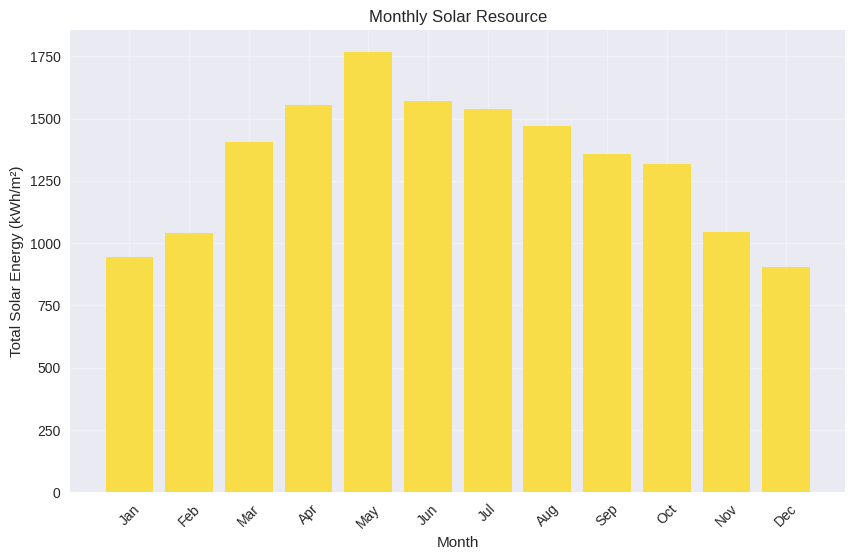

In [18]:
# Plot 4: Monthly Solar Resource
fig = plt.figure(figsize=(10, 6))
monthly_solar = []
for month in range(12):
    start_day = sum([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31][:month])
    end_day = start_day + [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31][month]
    month_data = solar_irradiance[start_day*24:end_day*24]
    monthly_solar.append(np.sum(month_data))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.bar(months, monthly_solar, color='gold', alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Total Solar Energy (kWh/m²)')
plt.title('Monthly Solar Resource')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

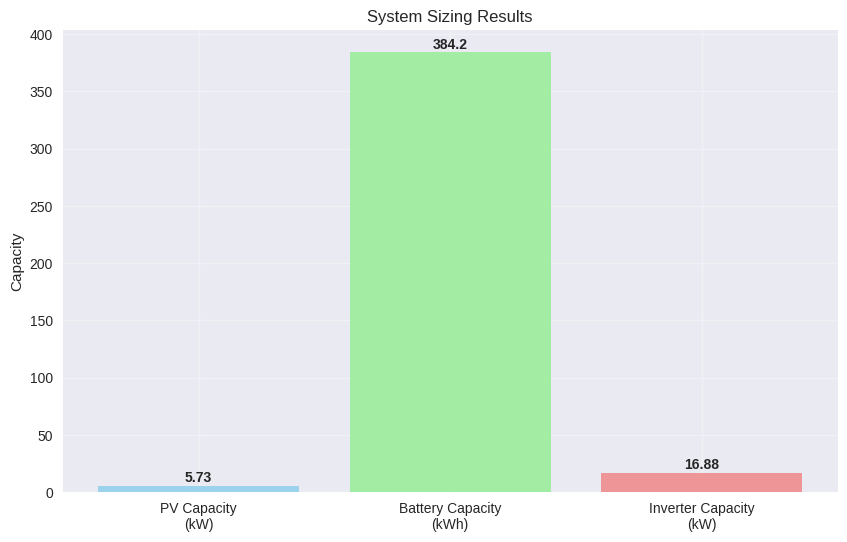

In [19]:
# Plot 5: System Sizing Results
fig = plt.figure(figsize=(10, 6))
components = ['PV Capacity\n(kW)', 'Battery Capacity\n(kWh)', 'Inverter Capacity\n(kW)']
values = [system_specs['PV_Capacity_kW'], system_specs['Battery_Capacity_kWh'],
          system_specs['Inverter_Capacity_kW']]
colors = ['skyblue', 'lightgreen', 'lightcoral']
bars = plt.bar(components, values, color=colors, alpha=0.8)
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{value}', ha='center', va='bottom', fontweight='bold')
plt.ylabel('Capacity')
plt.title('System Sizing Results')
plt.grid(True, alpha=0.3)

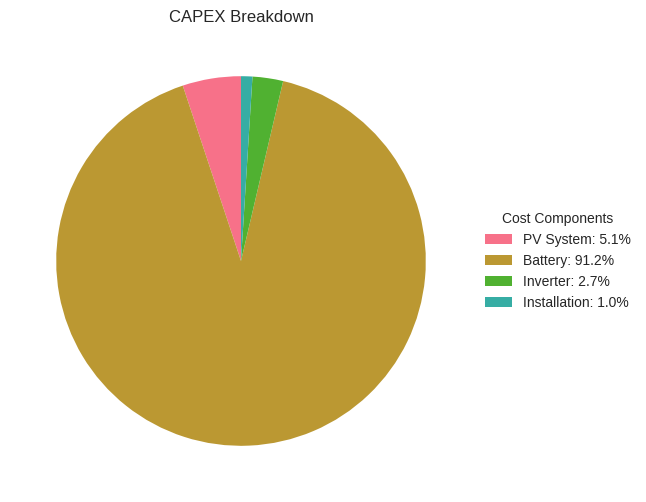

In [29]:

# Example data
cost_components = ['PV System', 'Battery', 'Inverter', 'Installation']
costs = [economics['PV_Cost'], economics['Battery_Cost'],
         economics['Inverter_Cost'], 50000]

# Calculate percentages
total_cost = sum(costs)
percentages = [f"{component}: {cost / total_cost * 100:.1f}%"
               for component, cost in zip(cost_components, costs)]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts = ax.pie(costs, startangle=90)

# Add legend on the right with labels and percentages
ax.legend(wedges, percentages, title="Cost Components", loc="center left", bbox_to_anchor=(1, 0.5))

ax.set_title('CAPEX Breakdown')
plt.show()


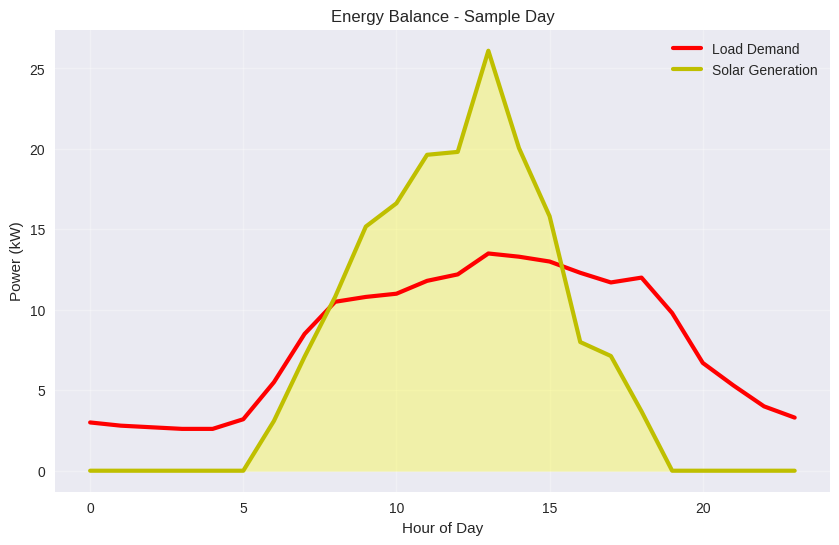

In [21]:
# Plot 7: Energy Balance (Sample Day)
fig = plt.figure(figsize=(10, 6))

sample_day_solar = solar_irradiance[:24] * system_specs['PV_Capacity_kW']
plt.plot(load_data['Hour'], load_data['Total_Load'], 'r-', linewidth=3, label='Load Demand')
plt.plot(load_data['Hour'], sample_day_solar, 'y-', linewidth=3, label='Solar Generation')
plt.fill_between(load_data['Hour'], sample_day_solar, alpha=0.3, color='yellow')
plt.xlabel('Hour of Day')
plt.ylabel('Power (kW)')
plt.title('Energy Balance - Sample Day')
plt.legend()
plt.grid(True, alpha=0.3)


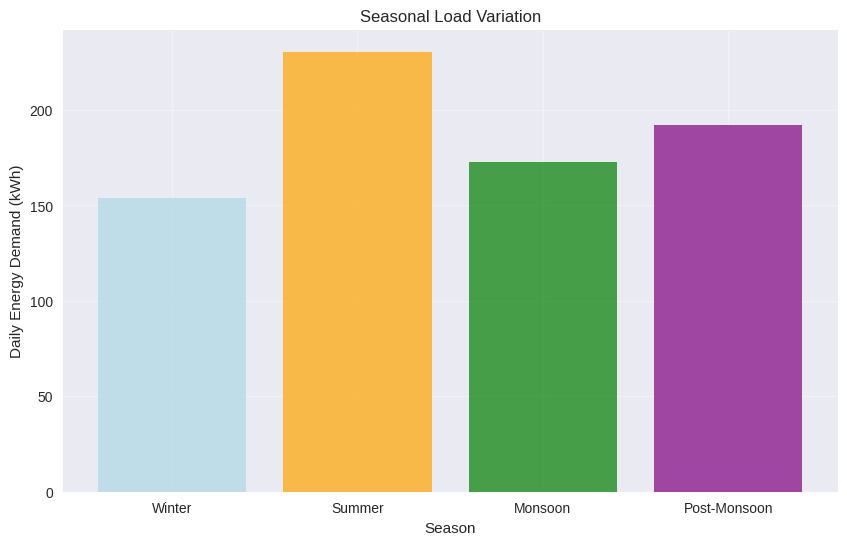

In [22]:

# Plot 8: Seasonal Load Variation
fig = plt.figure(figsize=(10, 6))

seasons = ['Winter', 'Summer', 'Monsoon', 'Post-Monsoon']
seasonal_multipliers = [0.8, 1.2, 0.9, 1.0]
seasonal_loads = [load_data['Total_Load'].sum() * mult for mult in seasonal_multipliers]
plt.bar(seasons, seasonal_loads, color=['lightblue', 'orange', 'green', 'purple'], alpha=0.7)
plt.xlabel('Season')
plt.ylabel('Daily Energy Demand (kWh)')
plt.title('Seasonal Load Variation')
plt.grid(True, alpha=0.3)

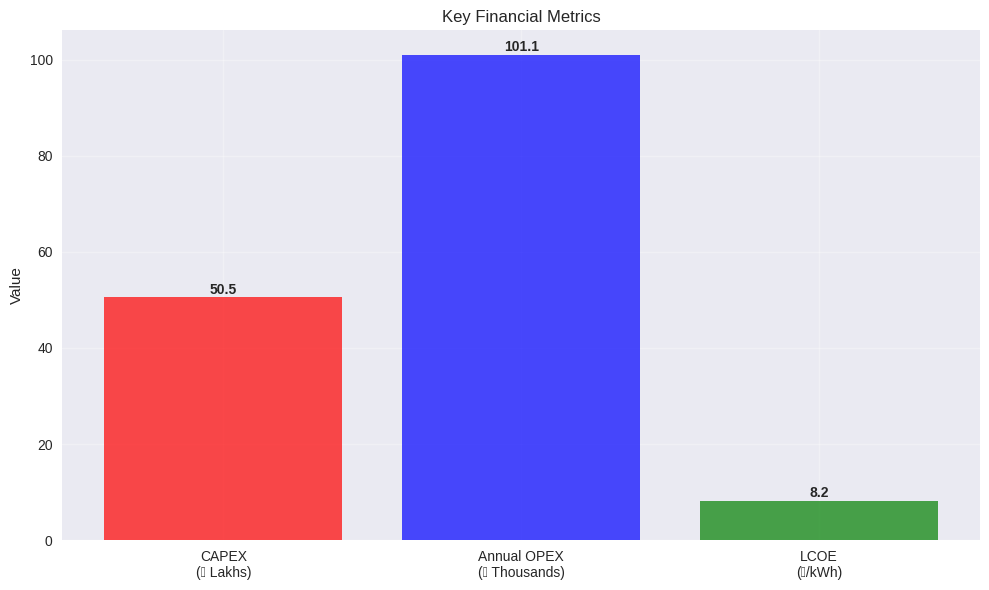

In [23]:
# Plot 9: Financial Metrics
fig = plt.figure(figsize=(10, 6))

metrics = ['CAPEX\n(₹ Lakhs)', 'Annual OPEX\n(₹ Thousands)', 'LCOE\n(₹/kWh)']
values = [economics['Total_CAPEX_INR']/100000, economics['Annual_OPEX_INR']/1000,
          economics['LCOE_INR_per_kWh']]
colors = ['red', 'blue', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
plt.ylabel('Value')
plt.title('Key Financial Metrics')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# SUMMARY RESULTS
print("="*60)
print("SOLAR-BATTERY MICROGRID ANALYSIS RESULTS")
print("="*60)
print("\n1. SYSTEM SPECIFICATIONS:")
for key, value in system_specs.items():
    print(f"   {key.replace('_', ' ')}: {value}")

print("\n2. ECONOMIC ANALYSIS:")
for key, value in economics.items():
    if 'INR' in key:
        print(f"   {key.replace('_', ' ')}: ₹{value:,.0f}")
    else:
        print(f"   {key.replace('_', ' ')}: {value}")

print("\n3. POLICY RECOMMENDATIONS:")
print("   - Eligible for PM-KUSUM Scheme (solar irrigation)")
print("   - Saubhagya Scheme for rural electrification")
print("   - State subsidies available for renewable energy")
print("   - Consider net metering for excess solar generation")

print("\n4. KEY INSIGHTS:")
print(f"   - Peak load occurs at {load_data.loc[load_data['Total_Load'].idxmax(), 'Hour']}:00 hours")
print(f"   - Solar capacity utilization: {(system_specs['Daily_Energy_Demand_kWh']/(system_specs['PV_Capacity_kW']*5.5))*100:.1f}%")
print(f"   - Battery provides {system_specs['Battery_Capacity_kWh']/system_specs['Daily_Energy_Demand_kWh']:.1f} days autonomy")
print(f"   - LCOE competitive with grid electricity (₹{economics['LCOE_INR_per_kWh']}/kWh)")

SOLAR-BATTERY MICROGRID ANALYSIS RESULTS

1. SYSTEM SPECIFICATIONS:
   PV Capacity kW: 5.73
   Battery Capacity kWh: 384.2
   Inverter Capacity kW: 16.88
   Daily Energy Demand kWh: 192.1
   Peak Load kW: 13.5

2. ECONOMIC ANALYSIS:
   Total CAPEX INR: ₹5,053,290
   Annual OPEX INR: ₹101,066
   LCOE INR per kWh: ₹8
   PV Cost: 257850.00000000003
   Battery Cost: 4610400.0
   Inverter Cost: 135040.0

3. POLICY RECOMMENDATIONS:
   - Eligible for PM-KUSUM Scheme (solar irrigation)
   - Saubhagya Scheme for rural electrification
   - State subsidies available for renewable energy
   - Consider net metering for excess solar generation

4. KEY INSIGHTS:
   - Peak load occurs at 13:00 hours
   - Solar capacity utilization: 609.6%
   - Battery provides 2.0 days autonomy
   - LCOE competitive with grid electricity (₹8.19/kWh)
